# Kaggle Notebooks Analysis

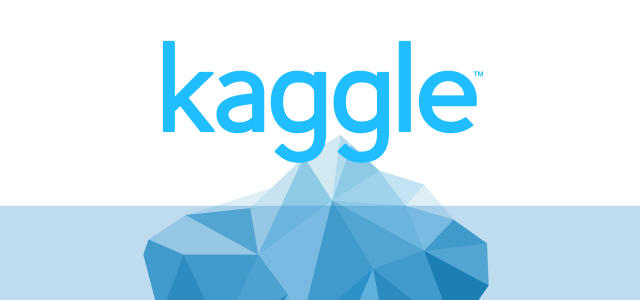

# Table of Contents

- 1. Dataset and Dependencies
   - 1.1 Importing the necessary libraries
   - 1.2 Reading in the Dataset
- 2. General EDA
   - 2.1 Missing Values
- 3. Detailed Analysis
   - 3.1 Distribution of cell type column
   - 3.2 An example of each cell type
- 4. Text Data Preprocessing
    - 4.1 Cleaning Codes and Markdown Text
- 5. Text Statistics
   - 5.1 Source Length Analysis
   - 5.2 Word Count Analysis
- 6. Ngram Analysis
    - 6.1 Top 20 Unigrams in Code and Markdown Cells
    - 6.2 Top 20 Bigrams in Code and Markdown Cells
    - 6.3 Top 20 Trigrams in Code and Markdown Cells
- 7. Wordclouds
- 8. Interesting Insights

# 1. Dataset and Dependencies 📃

## 1.1 Importing the necessary libraries

In [ ]:
# general dependencies
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords
import wordcloud

# sklearn libraries
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [ ]:
sns.set(style="whitegrid", palette="muted")
sns.set(rc={'figure.figsize':(11.7,8.27)})

## 1.2 Reading in the Dataset

Pandas Dataframe used is created by Darien Schettler. 

Link to dataset - https://www.kaggle.com/datasets/dschettler8845/ai4code-train-dataframe

In [ ]:
## Reading the train dataframe
train = pd.read_csv("../input/ai4code-train-dataframe/train.csv")

# 2. General EDA 📊

## 2.1 Overview of the data

In [ ]:
train.head()

In [ ]:
train.info()

In [ ]:
train.shape, train.nunique()

* Training dataframe has 6370646 records and 4 features.

* There are two cell types: codes and markdowns

* Source column contains text data for the corresponding cell.

In [ ]:
print(f"Number of notebooks present in train set: ",len(os.listdir("../input/AI4Code/train")))
print(f"Number of notebooks present in test set: ",len(os.listdir("../input/AI4Code/test")))

## 2.2 Missing Values

In [ ]:
train.isna().sum()

Since there are only 4 missing values, let's drop them from our analysis.

In [ ]:
train = train.dropna()

# 3. Detailed Analysis 🔎

## 3.1 Distribution of cell type column

In [ ]:
train['cell_type'].value_counts()

In [ ]:
#Checking the distribution of cell type variable

celltype1 = train['cell_type'].value_counts()['markdown']
celltype0 = train['cell_type'].value_counts()['code']
celltype1per = celltype1 / train.shape[0] * 100
celltype0per = celltype0 / train.shape[0] * 100

print('{} of {} records are codes it is the {:.2f}% of the training set.'.format(celltype0, train.shape[0], celltype0per))
print('{} of {} records are markdowns and it is the {:.2f}% of the training set.'.format(celltype1, train.shape[0], celltype1per))

plt.figure(figsize=(8,6))
sns.countplot(train['cell_type'], palette = 'viridis', order = sorted(train['cell_type'].unique()))

plt.xlabel('celltype', size=12, labelpad=15)
plt.ylabel('Count', size=12, labelpad=15)
plt.xticks((0, 1), ['Code ({0:.2f}%)'.format(celltype0per), 'Markdown ({0:.2f}%)'.format(celltype1per)])
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.title('Training Data Cell type Distribution', size=15, y=1.05)
plt.show()

2/3rd of the records contain Codes and 1/3rd contains Markdown text.

## 3.2 An example of each cell type

In [ ]:
# Code
print("Code :\n",train[train['cell_type']=='code']['source'].values[0])
print("*"*40)
# Markdown
print("\nMarkdown :\n",train[train['cell_type']=='markdown']['source'].values[0])

# 4. Text Data Preprocessing ✨

In [ ]:
#Performing the below analysis only on a sample to save memory
train = train.sample(500000, random_state = 1)

## 4.1 Cleaning Codes and Markdown Text

Let's create a function to clean the codes and markdown text. Following tasks are performed on the text data:

1. Make text lowercase
2. Remove hyperlinks
3. Remove punctuation
4. Remove numbers
5. Tokenize the text
6. Remove stopwords

In [ ]:
####Source: https://www.kaggle.com/code/parulpandey/eda-and-preprocessing-for-bert

# text preprocessing helper functions

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = text.strip()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    combined_text = ' '.join(tokenized_text)
    return combined_text

# code text preprocessing helped functions

def clean_code(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.replace('[', ' ').replace(']', ' ').replace('(', ' ').replace(')', ' ').replace('{', ' ').replace('}', ' ').replace('=', ' ').replace(',', ' ')
    text = text.lower()
    text = text.replace('_', '')
    text = text.replace('\n', ' ')
    text = text.replace('.', ' ')
    text = re.sub(r'".*"', ' ', text)
    text = re.sub(r"'.*'", ' ', text)
    text = re.sub("^\d+\s|\s\d+\s|\s\d+$", ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.strip()
    return text

def code_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_code(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    combined_text = ' '.join(tokenized_text)
    return combined_text

In [ ]:
#Let's divide the data by cell type

markdowns = train[train['cell_type'] == 'markdown']
codes = train[train['cell_type'] == 'code']

In [ ]:
# Applying the cleaning function on codes and markdown data

codes['source_clean'] = codes['source'].apply(str).apply(lambda x: code_preprocessing(x))
markdowns['source_clean'] = markdowns['source'].apply(str).apply(lambda x: text_preprocessing(x))

In [ ]:
#Concatenating clean text into train data

train = pd.concat([codes, markdowns], ignore_index = True)

# 5. Text Statistics 📉

Let's create two new features to help us understand this data and do the below analysis:

1. Text length analysis
2. Word Count analysis

In [ ]:
train['text_len'] = train['source_clean'].astype(str).apply(len)
train['text_word_count'] = train['source_clean'].apply(lambda x: len(str(x).split()))

In [ ]:
markdowns = train[train['cell_type'] == 'markdown']
codes = train[train['cell_type'] == 'code']

In [ ]:
train.head()

## 5.1 Source Length Analysis

Plotting all values result in a highly skewed distribution.

Let's plot only the most frequent values.

In [ ]:
x = train['text_len'].value_counts()
train_sample = train[train['text_len'].isin(x[x>200].index)]

In [ ]:
sns.kdeplot(data=train_sample, x="text_len", hue = 'cell_type', palette = 'viridis', shade = True)
plt.title('Text Character Length Countplot', size=12)
plt.xlabel('Character Length', size=10, labelpad=10)
plt.show()

Most people prefer to write short text. (Just like this one.)

In [ ]:
sns.boxplot(data=train,x = 'cell_type', y="text_len", palette = 'viridis', showfliers = False)
plt.title('Text Character Length Boxplot', size=15)
plt.show()

We can see that markdowns are generally longer than code snippet.

Median Code length is slightly above 50 characters and median Markdown length is slightly above that of the code. 

## 5.2 Word Count Analysis

In [ ]:
x = train['text_word_count'].value_counts()
train_sample = train[train['text_word_count'].isin(x[x>200].index)]

sns.kdeplot(data=train_sample, x="text_word_count", hue = 'cell_type', palette = 'viridis', shade = True)

plt.title('Text Word Countplot', size=12)
plt.xlabel('Word Count', size=10, labelpad=10)
plt.show()

In [ ]:
sns.boxplot(data=train,x = 'cell_type', y="text_word_count", palette = 'viridis', showfliers = False)
plt.title('Word Count Boxplot', size=15)
plt.show()

Again, We can confirm that markdowns are generally longer than code snippet.

Median Code word count is about 8 words and median Markdown word count is slightly above that of the code. 

# 6. Ngram Analysis 📈

## 6.1 Top 20 Unigrams in Code and Markdown Cells

In [ ]:
#source of code : https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
codes_unigrams = get_top_n_words(codes['source_clean'],20)

df1 = pd.DataFrame(codes_unigrams, columns = ['Text' , 'count'])
df1 = df1.groupby('Text').sum()['count'].sort_values(ascending=False)
df1 = pd.DataFrame(df1).reset_index()
sns.barplot(y = 'Text', x = 'count', data = df1, palette = 'viridis')
plt.title('Top 20 Code Unigrams', size=15)
plt.show()

Most common keywords found in code snippets are:

1. Import
2. plt
3. df
4. data
5. print

In [ ]:
markdowns_unigrams = get_top_n_words(markdowns['source_clean'],20)

df2 = pd.DataFrame(markdowns_unigrams, columns = ['Text' , 'count'])
df2 = df2.groupby('Text').sum()['count'].sort_values(ascending=False)
df2 = pd.DataFrame(df2).reset_index()
sns.barplot(y = 'Text', x = 'count', data = df2, palette = 'viridis')
plt.title('Top 20 Markdown Unigrams', size=15)
plt.show()

Most common keywords found in Markdown text are:

1. data
2. model
3. dataset
4. values
5. use

## 6.2 Top 20 Bigrams in Code and Markdown Cells

In [ ]:
def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
codes_bigrams = get_top_n_gram(codes['source_clean'],(2,2),20)

#for word, freq in top_bigrams:
df1 = pd.DataFrame(codes_bigrams, columns = ['Text' , 'count'])
df1 = df1.groupby('Text').sum()['count'].sort_values(ascending=False)
df1 = pd.DataFrame(df1).reset_index()
sns.barplot(y = 'Text', x = 'count', data = df1, palette = 'viridis')
plt.title('Top 20 Code Bigrams', size=15)
plt.show()

Most common bigrams found in Code snippets are:

1. plt.figure
2. pd.read_csv 
3. figure.figsize
4. xtrain, ytrain
5. pd.DataFrame

In [ ]:
markdowns_bigrams = get_top_n_gram(markdowns['source_clean'],(2,2),20)

#for word, freq in top_bigrams:
df2 = pd.DataFrame(markdowns_bigrams, columns = ['Text' , 'count'])
df2 = df2.groupby('Text').sum()['count'].sort_values(ascending=False)
df2 = pd.DataFrame(df2).reset_index()
sns.barplot(y = 'Text', x = 'count', data = df2, palette = 'viridis')
plt.title('Top 20 Markdown Bigrams', size=15)
plt.show()

Most common bigrams found in Markdown text are:

1. missing values
2. machine learning
3. random forest (Most Famous ML Algorithm)
4. data analysis
5. logistic regression

## 6.3 Top 20 Trigrams in Code and Markdown Cells

In [ ]:
codes_bigrams = get_top_n_gram(codes['source_clean'],(3,3),20)

#for word, freq in top_bigrams:
df1 = pd.DataFrame(codes_bigrams, columns = ['Text' , 'count'])
df1 = df1.groupby('Text').sum()['count'].sort_values(ascending=False)
df1 = pd.DataFrame(df1).reset_index()
sns.barplot(y = 'Text', x = 'count', data = df1, palette = 'viridis')
plt.title('Top 20 Code Trigrams', size=15)
plt.show()

Most common trigrams found in Code snippets are:

1. plt.figure.figsize
2. import numpy as np
3. import pandas as pd
4. import matplotlib.pyplot
5. matplot.pyplot as plt

In [ ]:
markdowns_bigrams = get_top_n_gram(markdowns['source_clean'],(3,3),20)

#for word, freq in top_bigrams:
df2 = pd.DataFrame(markdowns_bigrams, columns = ['Text' , 'count'])
df2 = df2.groupby('Text').sum()['count'].sort_values(ascending=False)
df2 = pd.DataFrame(df2).reset_index()
sns.barplot(y = 'Text', x = 'count', data = df2, palette = 'viridis')
plt.title('Top 20 Markdown Trigrams', size=15)
plt.show()

Most common trigrams found in Markdown text are:

1. exploratory data analysis
2. random forest classifier
3. machine learning model
4. train test data
5. machine learning algorithms

# 7. Wordclouds ☁️

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=2000000,
        max_font_size=40, 
        scale=2,
        random_state=1).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [ ]:
print("Word Cloud for Codes")
show_wordcloud(codes['source_clean'].values)
print("\nWord Cloud for Markdowns")
show_wordcloud(markdowns['source_clean'].values)

# 8. Interesting Insights 🥇🥈🥉

## 8.1 Kaggler's Favorite Library 🏆

Let's find out which is the library is the most famous on Kaggle

In [ ]:
codes_import = codes[codes['source_clean'].str.contains('import')]

codes_unigrams = get_top_n_words(codes_import['source_clean'],10)[1:]

df1 = pd.DataFrame(codes_unigrams, columns = ['Text' , 'count'])
df1 = df1.groupby('Text').sum()['count'].sort_values(ascending=False)
df1 = pd.DataFrame(df1).reset_index()
sns.barplot(y = 'Text', x = 'count', data = df1, palette = 'viridis')
plt.title('Most Famous Dependencies', size=15)
plt.show()

Most Famous Python Libraries on Kaggle:

1. Sklearn
2. Matplotlib
3. Numpy
4. Pandas

**Sklearn is the most famous library! It has been imported maximum number of times.**

## 8.2 Favorite ML Algorithms 🥇
For proof, check the bigrams and trigrams above.

1. Random Forest Classifier
2. Logistic Regression
3. Support Vector Machine
4. Decision Trees
5. Linear Regression

# The End!
Thank you for reading this notebook. I hope you found this analysis interesting and useful.

### Please upvote if you liked the analysis. It will motivate me to do better :)
![](http://68.media.tumblr.com/e1aed171ded2bd78cc8dc0e73b594eaf/tumblr_o17frv0cdu1u9u459o1_500.gif)